Wrote per_file_summaryOS.csv
Saved sorted plots and updated CSV/XLSX.
Wrote Excel summary to per_file_resultsOS.xlsx


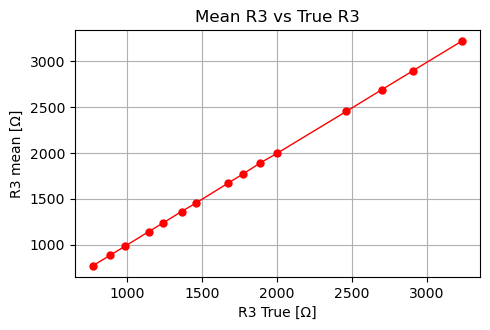

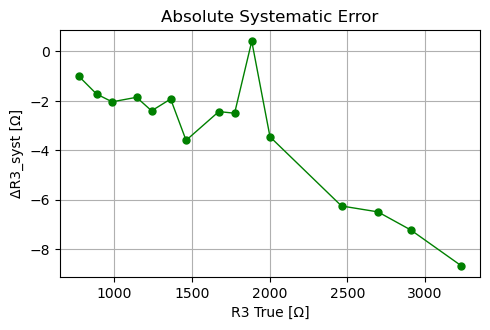

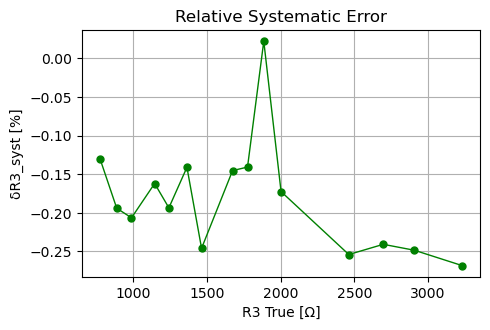

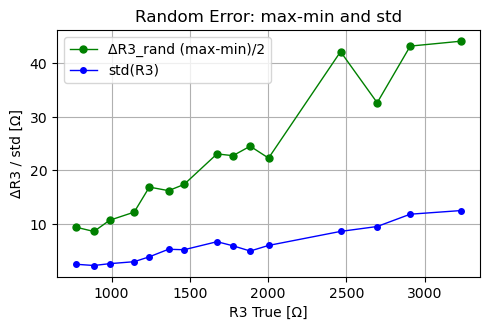

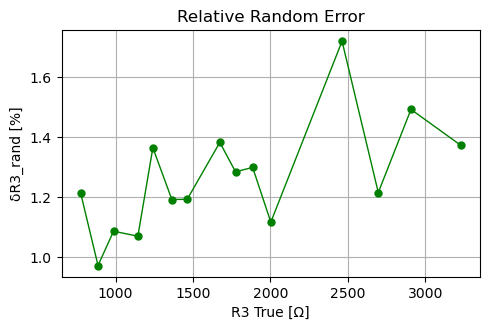

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import pandas as pd

DATA_FOLDER = "data"
R2 = 1000.1 
OUT_XLSX = "per_file_resultsOS.xlsx"

def load_triplets(path):
    D1=[]; D2=[]; D3=[]
    with open(path,'r',errors='ignore') as f:
        for L in f:
            L = L.strip()
            if not L.startswith(">>"):
                continue
            if "START" in L or "DONE" in L:
                continue
            L = L.replace(">>","").strip()
            parts = [p.strip() for p in L.split(',') if p.strip()!='']
            if len(parts) != 3:
                continue
            try:
                d1,d2,d3 = map(int, parts)
            except:
                continue
            D1.append(d1); D2.append(d2); D3.append(d3)
    return np.array(D1,dtype=int), np.array(D2,dtype=int), np.array(D3,dtype=int)

def compute_R3_array(D1,D2,D3,R2):
    D1 = D1.astype(float); D2 = D2.astype(float); D3 = D3.astype(float)
    num = (D2 - D1); den = (D3 - D2)
    with np.errstate(divide='ignore', invalid='ignore'):
        R3 = R2 * (num/den)
    return R3 
files = sorted([f for f in os.listdir(DATA_FOLDER) if f.endswith('.txt')])
if not files:
    raise SystemExit("No .txt files in data/ folder.")

summary = []
for fn in files:
    path = os.path.join(DATA_FOLDER, fn)
    try:
        true_val = float(fn.replace('.txt','').replace('-', '.'))
    except:
        print("[WARN] skipping file with unparsable name:", fn)
        continue

    D1,D2,D3 = load_triplets(path)
    n_total = len(D1)
    if n_total == 0:
        summary.append((fn, true_val, 0, 0, 1.0, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan))
        print(f"[WARN] {fn}: zero samples")
        continue

    R3_all = compute_R3_array(D1,D2,D3,R2)
    valid_mask = np.isfinite(R3_all)
    n_valid = int(np.sum(valid_mask))
    frac_invalid = 1.0 - (n_valid / float(n_total))

    if n_valid > 0:
        R3_valid = R3_all[valid_mask]
        mean_R3 = float(np.mean(R3_valid))
        min_R3  = float(np.min(R3_valid))
        max_R3  = float(np.max(R3_valid))
        std_R3  = float(np.std(R3_valid, ddof=0))
        p10 = float(np.percentile(R3_valid,10))
        p90 = float(np.percentile(R3_valid,90))
    else:
        mean_R3 = min_R3 = max_R3 = std_R3 = p10 = p90 = np.nan

    summary.append((fn, true_val, n_total, n_valid, frac_invalid, mean_R3, min_R3, max_R3, std_R3, p10, p90))

# write summary csv for quick eyeballing (optional)
with open("per_file_summaryOS.csv","w",newline='') as f:
    w = csv.writer(f)
    w.writerow(['file','true_R3','n_samples','n_valid','frac_invalid','mean_R3','min_R3','max_R3','std_R3','p10','p90'])
    for row in summary:
        w.writerow(row)
print("Wrote per_file_summaryOS.csv")

# Filter out entries with no valid samples, then sort by true_R3
valid_entries = [r for r in summary if (r[2] > 0 and not np.isnan(r[5]))]
if len(valid_entries) == 0:
    raise SystemExit("No valid data to plot after scanning files.")

valid_entries.sort(key=lambda x: x[1])  # sort by true_R3 numeric value
true_R3_sorted = np.array([r[1] for r in valid_entries])
mean_sorted    = np.array([r[5] for r in valid_entries])
min_sorted     = np.array([r[6] for r in valid_entries])
max_sorted     = np.array([r[7] for r in valid_entries])
std_sorted     = np.array([r[8] for r in valid_entries])
Delta_syst = (mean_sorted - true_R3_sorted) / 2.0
delta_syst = 100.0 * Delta_syst / true_R3_sorted
Delta_rand = (max_sorted - min_sorted) / 2.0
delta_rand = 100.0 * Delta_rand / mean_sorted
for fn, true_val, n_total, n_valid, frac_invalid, mean_R3, min_R3, max_R3, std_R3, p10, p90 in summary:
    if n_total == 0:
        print("[SKIP] ", fn, " no samples")
    elif frac_invalid > 0.5:
        print("[WARN] High invalid fraction >", frac_invalid, "in", fn)
    elif n_valid < 50:
        print("[WARN] Low valid count (", n_valid, ") in", fn)

fs = (5, 3.2)
plt.figure(figsize=fs)
plt.plot(true_R3_sorted, mean_sorted, 'ro-', ms=5, lw=1)
plt.xlabel("R3 True [Ω]"); plt.ylabel("R3 mean [Ω]"); plt.grid(True); plt.tight_layout()
plt.title("Mean R3 vs True R3")
plt.savefig("plot1_mean_vs_true_sortedOS.png", dpi=300)

plt.figure(figsize=fs)
plt.plot(true_R3_sorted, Delta_syst, 'go-', ms=5, lw=1)
plt.xlabel("R3 True [Ω]"); plt.ylabel("ΔR3_syst [Ω]"); plt.grid(True); plt.tight_layout()
plt.title("Absolute Systematic Error")
plt.savefig("plot2_abs_syst_sortedOS.png", dpi=300)

plt.figure(figsize=fs)
plt.plot(true_R3_sorted, delta_syst, 'go-', ms=5, lw=1)
plt.xlabel("R3 True [Ω]"); plt.ylabel("δR3_syst [%]"); plt.grid(True); plt.tight_layout()
plt.title("Relative Systematic Error")
plt.savefig("plot3_rel_syst_sortedOS.png", dpi=300)
plt.figure(figsize=fs)
plt.plot(true_R3_sorted, Delta_rand, 'go-', ms=5, lw=1, label='ΔR3_rand (max-min)/2')
plt.plot(true_R3_sorted, std_sorted,  'b-o', ms=4, lw=1, label='std(R3)')
plt.xlabel("R3 True [Ω]"); plt.ylabel("ΔR3 / std [Ω]"); plt.grid(True); plt.tight_layout()
plt.title("Random Error: max-min and std")
plt.legend()
plt.savefig("plot4_rand_and_std_sortedOS.png", dpi=300)
plt.figure(figsize=fs)
plt.plot(true_R3_sorted, delta_rand, 'go-', ms=5, lw=1)
plt.xlabel("R3 True [Ω]"); plt.ylabel("δR3_rand [%]"); plt.grid(True); plt.tight_layout()
plt.title("Relative Random Error")
plt.savefig("plot5_rel_rand_sortedOS.png", dpi=300)

print("Saved sorted plots and updated CSV/XLSX.")
df = pd.DataFrame(valid_entries, columns=['file','true_R3','n_samples','n_valid','frac_invalid',
                                          'mean_R3','min_R3','max_R3','std_R3','p10','p90'])
df['Delta_syst'] = (df['mean_R3'] - df['true_R3'])/2.0
df['delta_syst_pct'] = 100.0 * df['Delta_syst'] / df['true_R3']
df['Delta_rand'] = (df['max_R3'] - df['min_R3'])/2.0
df['delta_rand_pct'] = 100.0 * df['Delta_rand'] / df['mean_R3']
df = df.sort_values(by='true_R3').reset_index(drop=True)
df.to_excel(OUT_XLSX, sheet_name='OSsummary', index=False, float_format="%.6f")
print(f"Wrote Excel summary to {OUT_XLSX}")
